In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import gc

%load_ext autoreload
%autoreload 2

In [5]:
# прописывем нужные нам пути
dir_project = 'git/proj_news_viz/nlp' # путь проекта

PATH = os.path.join(os.getenv('HOME'), dir_project)
sys.path.append(PATH)

In [184]:
import pandas as pd
import numpy as np

from datetime import datetime as time
from pprint import pprint

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore

from news_viz.visualization.visualize import plot_metrics
import matplotlib.pyplot as plt
%matplotlib inline

---
читаем данные

In [6]:
df = pd.read_csv(f'{PATH}/data/interim/news_lenta-cleaned-lemmatize.csv.gz', compression='gzip')
print(df.shape)
df.sample(2)

(674580, 2)


,url,lemma_text
565114,https://lenta.ru/world/2005/01/06/resign/,мужской сборная россия занять третье место эст...
74275,https://lenta.ru/news/2017/01/13/shadow_brokers/,канадский премьера осудить путешествие вертолё...


In [42]:
# преобразуем текст в список токенов
df['lemma_text_list'] = df.lemma_text.apply(lambda x: x.split())
df.sample(2)

,url,lemma_text,lemma_text_list
629957,https://lenta.ru/news/2002/02/25/lenfilm/,тягачев россия всё-таки участвовать церемония ...,"[тягачев, россия, всё-таки, участвовать, церем..."
85458,https://lenta.ru/news/2016/11/07/sex_robots/,уличить согласование вопрос трамп демократ сай...,"[уличить, согласование, вопрос, трамп, демокра..."


In [29]:
# проверим и удалим пустые записи и дубликаты
df.dropna(inplace=True)
df.lemma_text.drop_duplicates(inplace=True)

print(f'df.shape = {df.shape}')
df.isnull().sum()

df.shape = (674580, 2)


url           0
lemma_text    0
dtype: int64

---
### LDA

Для работы с LDA нам нужно подготовить 2 объекта:

1. словарь, в котором каждому слову присваивается уникальный id

In [43]:
%%time
dictionary = corpora.Dictionary(df.lemma_text_list)

CPU times: user 1min 57s, sys: 15.5 s, total: 2min 13s
Wall time: 2min 22s


In [47]:
len(dictionary)

460587

In [59]:
dictionary[0]

'ансворт'

2. список преобразованных текстов ("мешок слов" или tf-idf)

In [50]:
%%time
corpus = [dictionary.doc2bow(doc) for doc in df.lemma_text_list]

CPU times: user 1min 44s, sys: 1min 25s, total: 3min 10s
Wall time: 3min 41s


In [82]:
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]]


In [84]:
# или можем посмотреть более человеческим взглядом
print([[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('ансворт', 2), ('британский', 2), ('верна', 1), ('видеть', 1), ('внутри', 1), ('вскоре', 1), ('вход', 2), ('вызволять', 1), ('глубокий', 1), ('грот', 1), ('дайвера', 2), ('день', 1), ('десять', 1), ('детский', 1), ('дождь', 1), ('живой', 1), ('завалить', 1), ('засунуть', 1), ('затопить', 3), ('заявить', 1), ('идея', 1), ('илона', 2), ('инцидент', 1), ('исчезновение', 1), ('июль', 1), ('июнь', 1), ('камень', 1), ('километр', 1), ('команда', 1), ('крутой', 1), ('маск', 3), ('маска', 1), ('место', 1), ('миллиардер', 1), ('мини-субмарина', 1), ('морпех', 1), ('назвать', 2), ('найти', 1), ('один', 1), ('операция', 1), ('оппонент', 1), ('ответ', 1), ('ответить', 1), ('отделять', 1), ('отметить', 1), ('педофил', 2), ('пещера', 3), ('пиар-ход', 1), ('план', 1), ('по-настоящему', 1), ('подлодка', 1), ('поздний', 1), ('пойти', 1), ('посоветовать', 1), ('пошлый', 1), ('пропасть', 1), ('раскритиковать', 1), ('ребёнок', 3), ('резка', 1), ('свобода', 1), ('свой', 1), ('сидеть', 1), ('сначала', 1)

---
обучаем

In [197]:
def fit_tm_gensim(corpus: list=None,
                  dictionary: 'Dictionary'=None,
                  text: list=None,
                  range_topics: list=None,
                  passes: int=10,
                  per_word_topics: bool=True) -> (list, list, list):
    """
    fit topic modeling model gensim, multicore (using LdaMulticore) 
    
    Parameters
    ----------
    corpus : {iterable of list of (int, float), scipy.sparse.csc}
        Stream of document vectors or sparse matrix of shape (`num_terms`, `num_documents`)
    dictionary: {dict of (int, str),  :class:`gensim.corpora.dictionary.Dictionary`}
        Mapping from word IDs to words. It is used to determine the vocabulary size,
        as well as for debugging and topic printing.
    text : list
        list text tokens like text at `corpora.Dictionary`
    range_topics: list
        list range topics, like `[20, 25, 30, 35, 40]`
    passes: int (default = 10)
        number of passes through the corpus during training
    per_word_topics : bool (default = True)
        if True, the model also computes a list of topics, sorted in descending order of most likely
        topics for each word, along with their phi values multiplied by the feature length (i.e. word count)
    Returns
    -------
    meta_model : dict
        meta model fitted model
        with next items: model, coherence, perplexity, time
    """
    
#     model_list, perplexity, coherence = [], [], []
    meta_model = {}
    
    for num_topic in range_topics:
        print(f'#topic {num_topic} ..........')
        time_start = time.now()

        # fit models TM
        model_gensim = LdaMulticore(corpus=corpus,
                                    id2word=dictionary,
                                    num_topics=num_topic,
                                    passes=passes,
                                    per_word_topics=True)
#         model_list.append(model_gensim)
        
        # evaluation
        # coherence
        coherence_model = CoherenceModel(model=model_gensim,
                                         texts=text,
                                         dictionary=dictionary,
                                         coherence='c_v')
        coherence_value = coherence_model.get_coherence() 
#         coherence.append(coherence_value)
        
        # perplexity
        perplexity_value = model_gensim.log_perplexity(corpus)
#         perplexity.append(perplexity_value)
        
        print(f'\tcoherence score: {coherence_value}')
        print(f'\tperplexity score: {perplexity_value}')
        
        time_end = time.now() - time_start
        print(f'\n\ttime: {time_end}')
        
        meta_model[num_topic] = {'model': model_gensim,
                                 'coherence': coherence_value,
                                 'perplexity': perplexity_value,
                                 'time_fit': time_end
                                }

    return meta_model

In [198]:
%%time

steps = list(range(20,40+1,5))
meta_gensim_models = fit_tm_gensim(corpus=corpus,
                                   dictionary=dictionary,
                                   text=df.lemma_text_list,
                                   range_topics=steps,
                                   passes=10,
                                   per_word_topics=True)

#topic 20 ..........
	coherence score: 0.5170729444695467
	perplexity score: -8.157822119408696

	time: 1:31:04.028619
#topic 25 ..........
	coherence score: 0.5472689859626717
	perplexity score: -8.138857416693568

	time: 1:34:19.612590
#topic 30 ..........
	coherence score: 0.5592556719674803
	perplexity score: -8.111895116693027

	time: 1:50:52.987625
#topic 35 ..........
	coherence score: 0.559080688185608
	perplexity score: -8.114472441563107

	time: 1:48:40.609524
#topic 40 ..........
	coherence score: 0.5678071724555048
	perplexity score: -8.097399938034737

	time: 1:59:58.455732
CPU times: user 5h 28min 39s, sys: 1h 54min 33s, total: 7h 23min 12s
Wall time: 8h 44min 55s


In [199]:
pprint(meta_gensim_models)

{20: {'coherence': 0.5170729444695467,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x468545320>,
      'perplexity': -8.157822119408696,
      'time_fit': datetime.timedelta(0, 5464, 28619)},
 25: {'coherence': 0.5472689859626717,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x430592b70>,
      'perplexity': -8.138857416693568,
      'time_fit': datetime.timedelta(0, 5659, 612590)},
 30: {'coherence': 0.5592556719674803,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x46855c2e8>,
      'perplexity': -8.111895116693027,
      'time_fit': datetime.timedelta(0, 6652, 987625)},
 35: {'coherence': 0.559080688185608,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x457527b00>,
      'perplexity': -8.114472441563107,
      'time_fit': datetime.timedelta(0, 6520, 609524)},
 40: {'coherence': 0.5678071724555048,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x45753cac8>,
      'perplexity': -8.

----
нарисуем графики метрик

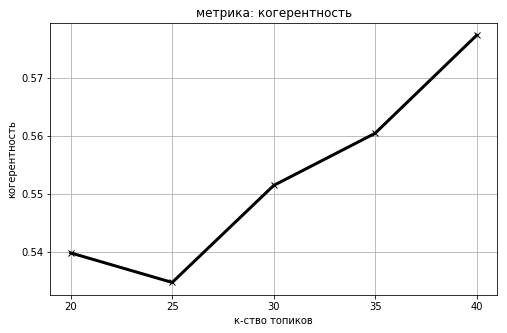

In [202]:
# когерентность
coherence_list = [meta_gensim_models[i]['coherence'] for i in meta_gensim_models.keys()]
plot_metrics(range_topics=steps, metric=coherence, title='когерентность')

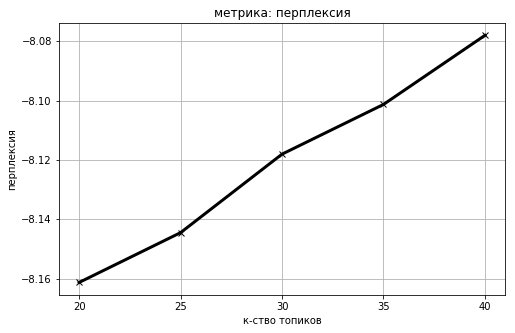

In [203]:
# перплексия
coherence_list = [meta_gensim_models[i]['perplexity'] for i in meta_gensim_models.keys()]
plot_metrics(range_topics=steps, metric=perplexity, title='перплексия')